# Decision Tree on Amazon Fine Food Reviews

## 1.Loading the data

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


## 2.Loading data From GoogleDrive

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')

In [ ]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 


## 3.Spliting CleanedText and Score into train and test

In [0]:
final=final.sort_values(by=['Time'],ascending=False)
finalDataPoints=final.head(100000)

x=finalDataPoints["CleanedText"]
y=finalDataPoints["Score"]



x_tr,x_test,y_tr,y_test=train_test_split(x, y, test_size=0.2,shuffle=False)

In [0]:
print(x_tr.shape,x_test.shape,y_tr.shape,y_test.shape)

(80000,) (20000,) (80000,) (20000,)


# 4.Bag of Words (BoW)

## 4.1 Unigram

In [0]:
#BOW for unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

## 4.1.1 Grid search

### 4.1.1.1 Finding the optimal MaxDepth using gridsearch

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 26.1min finished


Best HyperParameter:  {'max_depth': 43}
0.8374825418516963


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


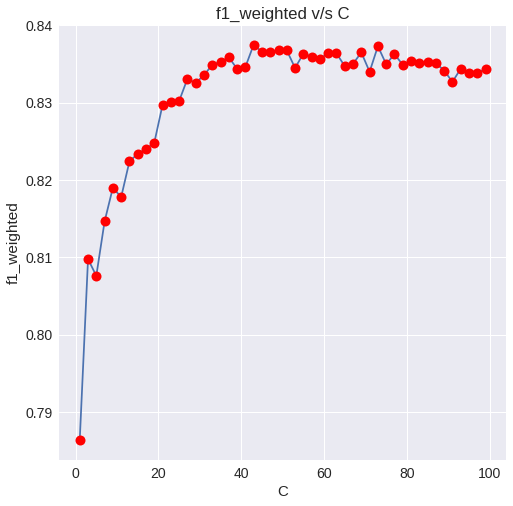

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))

DT = DecisionTreeClassifier()
max_depth = [{'max_depth': depth}]
gsv = GridSearchCV(DT,max_depth,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_depth=gsv.best_score_


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.1.1.2 finding the accuracy,F1-score in Test data using optimal MaxDepth

Accuracy on test set: 84.645%
Precision on test set: 0.740
Recall on test set: 0.677
F1-Score on test set: 0.700


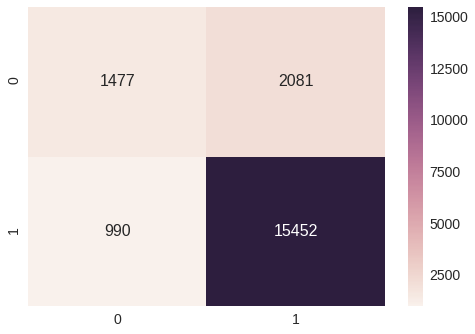

In [0]:
DT= DecisionTreeClassifier(max_depth=43)
fit=DT.fit(x_tr_uni,y_tr)
y_pred =DT.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.1.2 RandomSearchCV

### 4.1.2.1 Finding the optimal MaxDepth using RandomSearchCv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


Best HyperParameter:  {'max_depth': 47}
0.8376672061001514


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


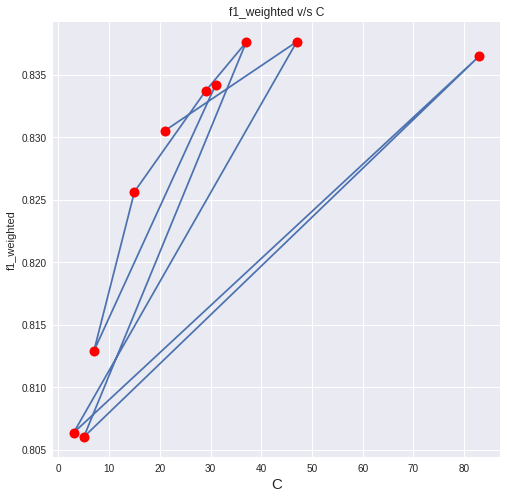

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))
DT = DecisionTreeClassifier()
max_depth = {'max_depth':depth}
gsv = RandomizedSearchCV(DT,max_depth,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_
x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.1.2.2 finding the accuracy,F1-score in Test data using optimal MaxDepth

Accuracy on test set: 84.565%
Precision on test set: 0.737
Recall on test set: 0.680
F1-Score on test set: 0.701


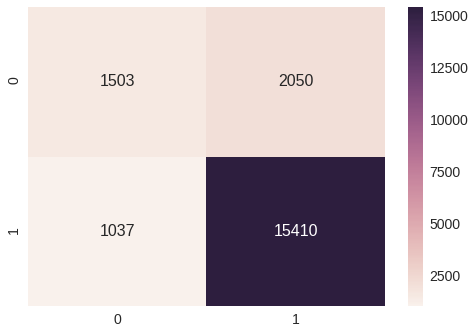

In [0]:
DT= DecisionTreeClassifier(max_depth=47)
DT.fit(x_tr_uni,y_tr)
y_pred =DT.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.1.3 Feature Importance

In [0]:
DT = DecisionTreeClassifier(max_depth=43)
DT.fit(x_tr_uni,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=43,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
features=(-DT.feature_importances_).argsort()
print(np.take(bow.get_feature_names(), features))

['disappoint' 'return' 'great' ... 'frodo' 'fudget' 'îts']


## 4.1.4 Decision Tree visualisation 

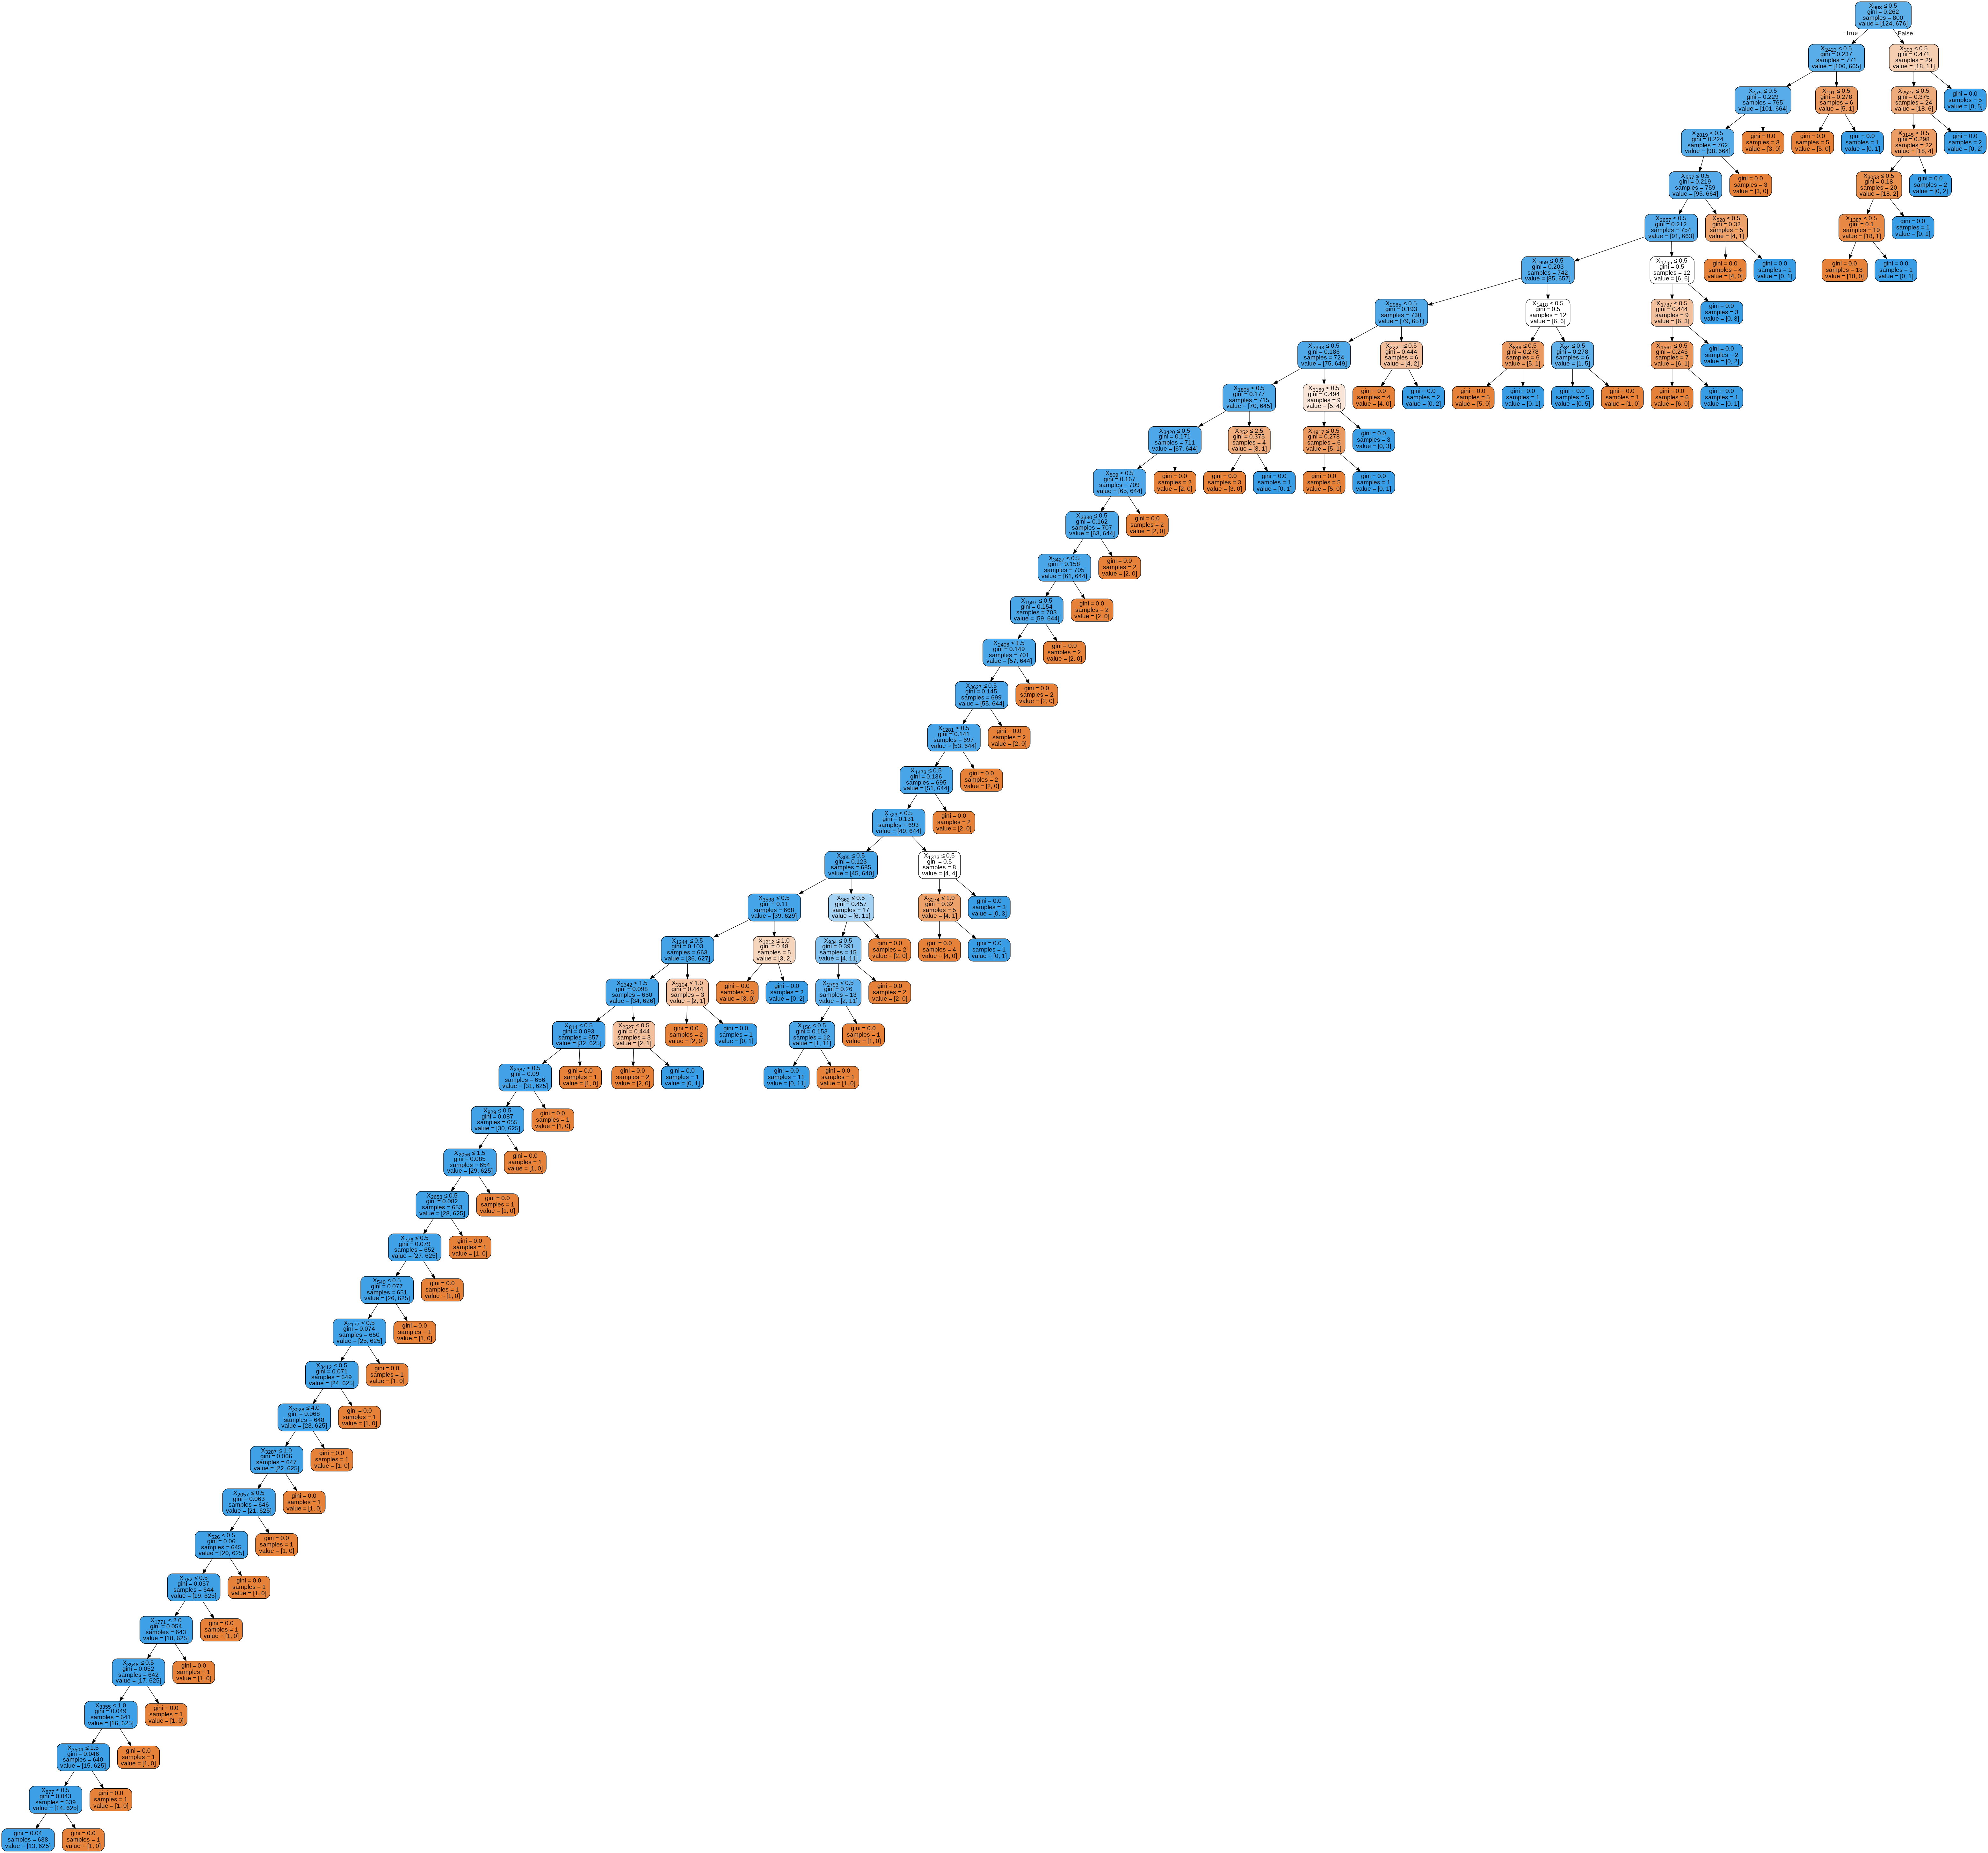

In [0]:
DT= DecisionTreeClassifier(max_depth=43)
fit=DT.fit(x_tr_uni,y_tr)
x_tr_uni_graphviz1=x_tr_uni.todense()
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 4.2 Bi-Grams


In [0]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(x_tr)
x_test_bi = bi_gram.transform(x_test)

## 4.2.1.1 GridSeach

### 4.2.1.1 Finding the optimal MaxDepth using gridsearchcv

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 20.7min finished


Best HyperParameter:  {'max_depth': 75}
0.8462502599392081


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


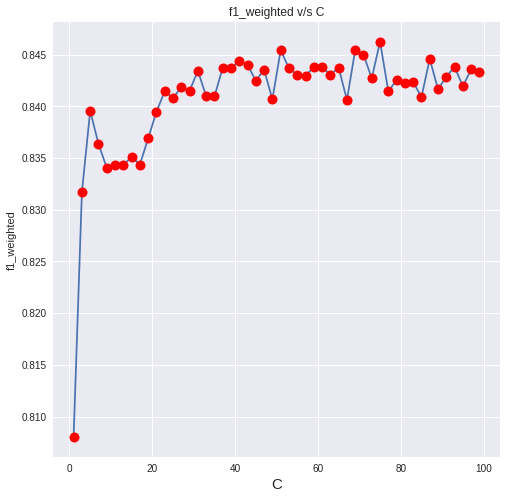

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))

DT = DecisionTreeClassifier()
C_value = [{'max_depth': depth}]
gsv = GridSearchCV(DT,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.2.1.2 finding the accuracy in Test data using optimal MaxDepth

Accuracy on test set: 85.275%
Precision on test set: 0.751
Recall on test set: 0.704
F1-Score on test set: 0.723


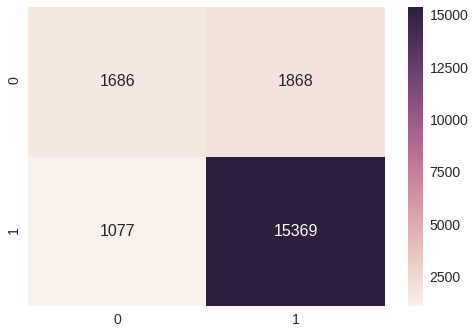

In [0]:
DT= DecisionTreeClassifier(max_depth=75)
DT.fit(x_tr_bi,y_tr)
y_pred =DT.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.2.1.2 Randomseachcv

### 4.2.1.1 Finding the optimal MaxDepth using RandomSearchCv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.4min finished


Best HyperParameter:  {'max_depth': 89}
0.8479529270972


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


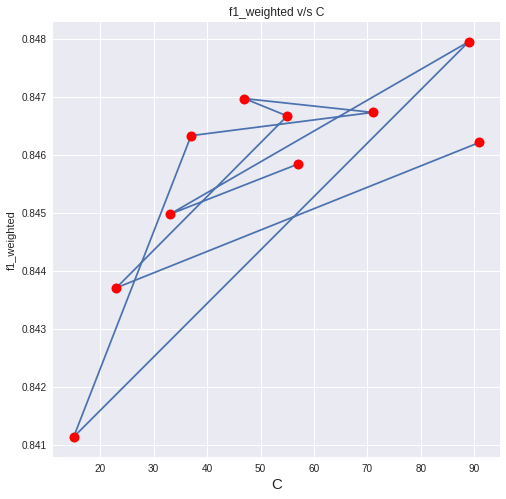

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))
DT = DecisionTreeClassifier()
max_depth = {'max_depth':depth}
gsv = RandomizedSearchCV(DT,max_depth,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 4.2.1.2 finding the accuracy,f1-score in Test data using optimal MaxDepth

Accuracy on test set: 85.335%
Precision on test set: 0.751
Recall on test set: 0.713
F1-Score on test set: 0.729


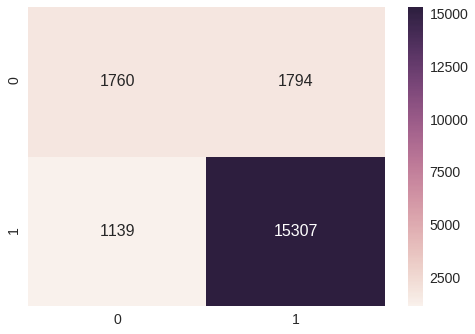

In [0]:
DT= DecisionTreeClassifier(max_depth=89)
DT.fit(x_tr_bi,y_tr)
y_pred =DT.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.2.3 Feature Importance

In [0]:
DT = DecisionTreeClassifier(max_depth=75)
DT.fit(x_tr_bi,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=75,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
features=(-DT.feature_importances_).argsort()
print(np.take(bi_gram.get_feature_names(), features))

['disappoint' 'return' 'great' ... 'flavor rich' 'flavor remark'
 'îts real']


## 4.1.4 Decision Tree visualisation 

In [0]:
DT= DecisionTreeClassifier(max_depth=75)
fit=DT.fit(x_tr_bi,y_tr)
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 5 TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

# 5.1 GridSearch

## 5.1.1 Finding the optimal MaxDepth using GridsearchCv

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 20.4min finished


Best HyperParameter:  {'max_depth': 53}
0.853763777872906


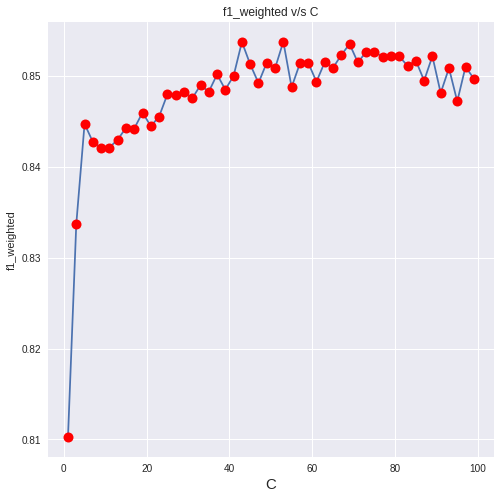

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))

DT = DecisionTreeClassifier()
C_value = [{'max_depth': depth}]
gsv = GridSearchCV(DT,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 5.1.2 finding the accuracy in Test data using optimal MaxDepth

Accuracy on test set: 84.600%
Precision on test set: 0.736
Recall on test set: 0.702
F1-Score on test set: 0.717


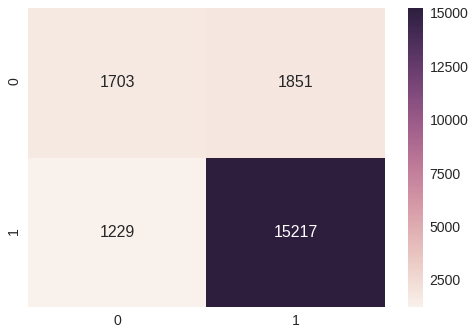

In [0]:
DT= DecisionTreeClassifier(max_depth=53)
DT.fit(x_tr_tfidf,y_tr)
y_pred =DT.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 5.2 RandomSearchCv

## 5.2.1 Finding the optimal MaxDepth using RandomSearchCv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.3min finished


Best HyperParameter:  {'max_depth': 33}
0.8452954128015254


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


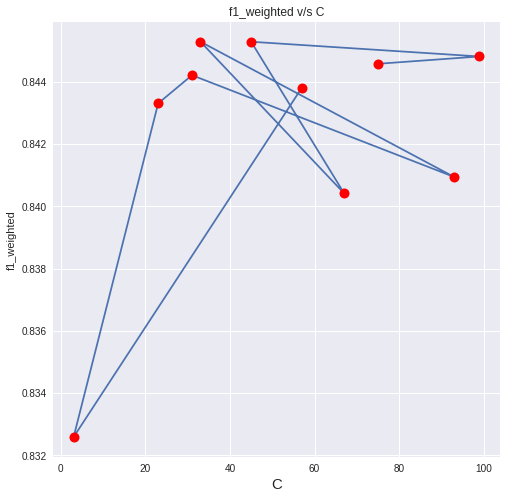

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))
DT = DecisionTreeClassifier()
max_depth = {'max_depth':depth}
gsv = RandomizedSearchCV(DT,max_depth,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 5.2.2 finding the accuracy in Test data using optimal MaxDepth

Accuracy on test set: 85.145%
Precision on test set: 0.760
Recall on test set: 0.661
F1-Score on test set: 0.690


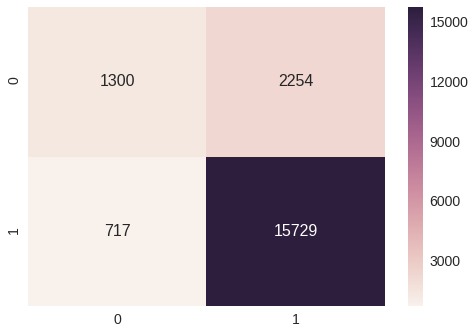

In [0]:
DT= DecisionTreeClassifier(max_depth=33)
DT.fit(x_tr_tfidf,y_tr)
y_pred =DT.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 5.1.3 Feature Importance

In [0]:
DT = DecisionTreeClassifier(max_depth=53)
DT.fit(x_tr_tfidf,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=53,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
features=(-DT.feature_importances_).argsort()
print(np.take(tf_idf_vect.get_feature_names(), features))

['disappoint' 'return' 'great' ... 'flavor pocki' 'flavor point'
 'îts real']


## 5.1.4 Decision Tree visualisation 

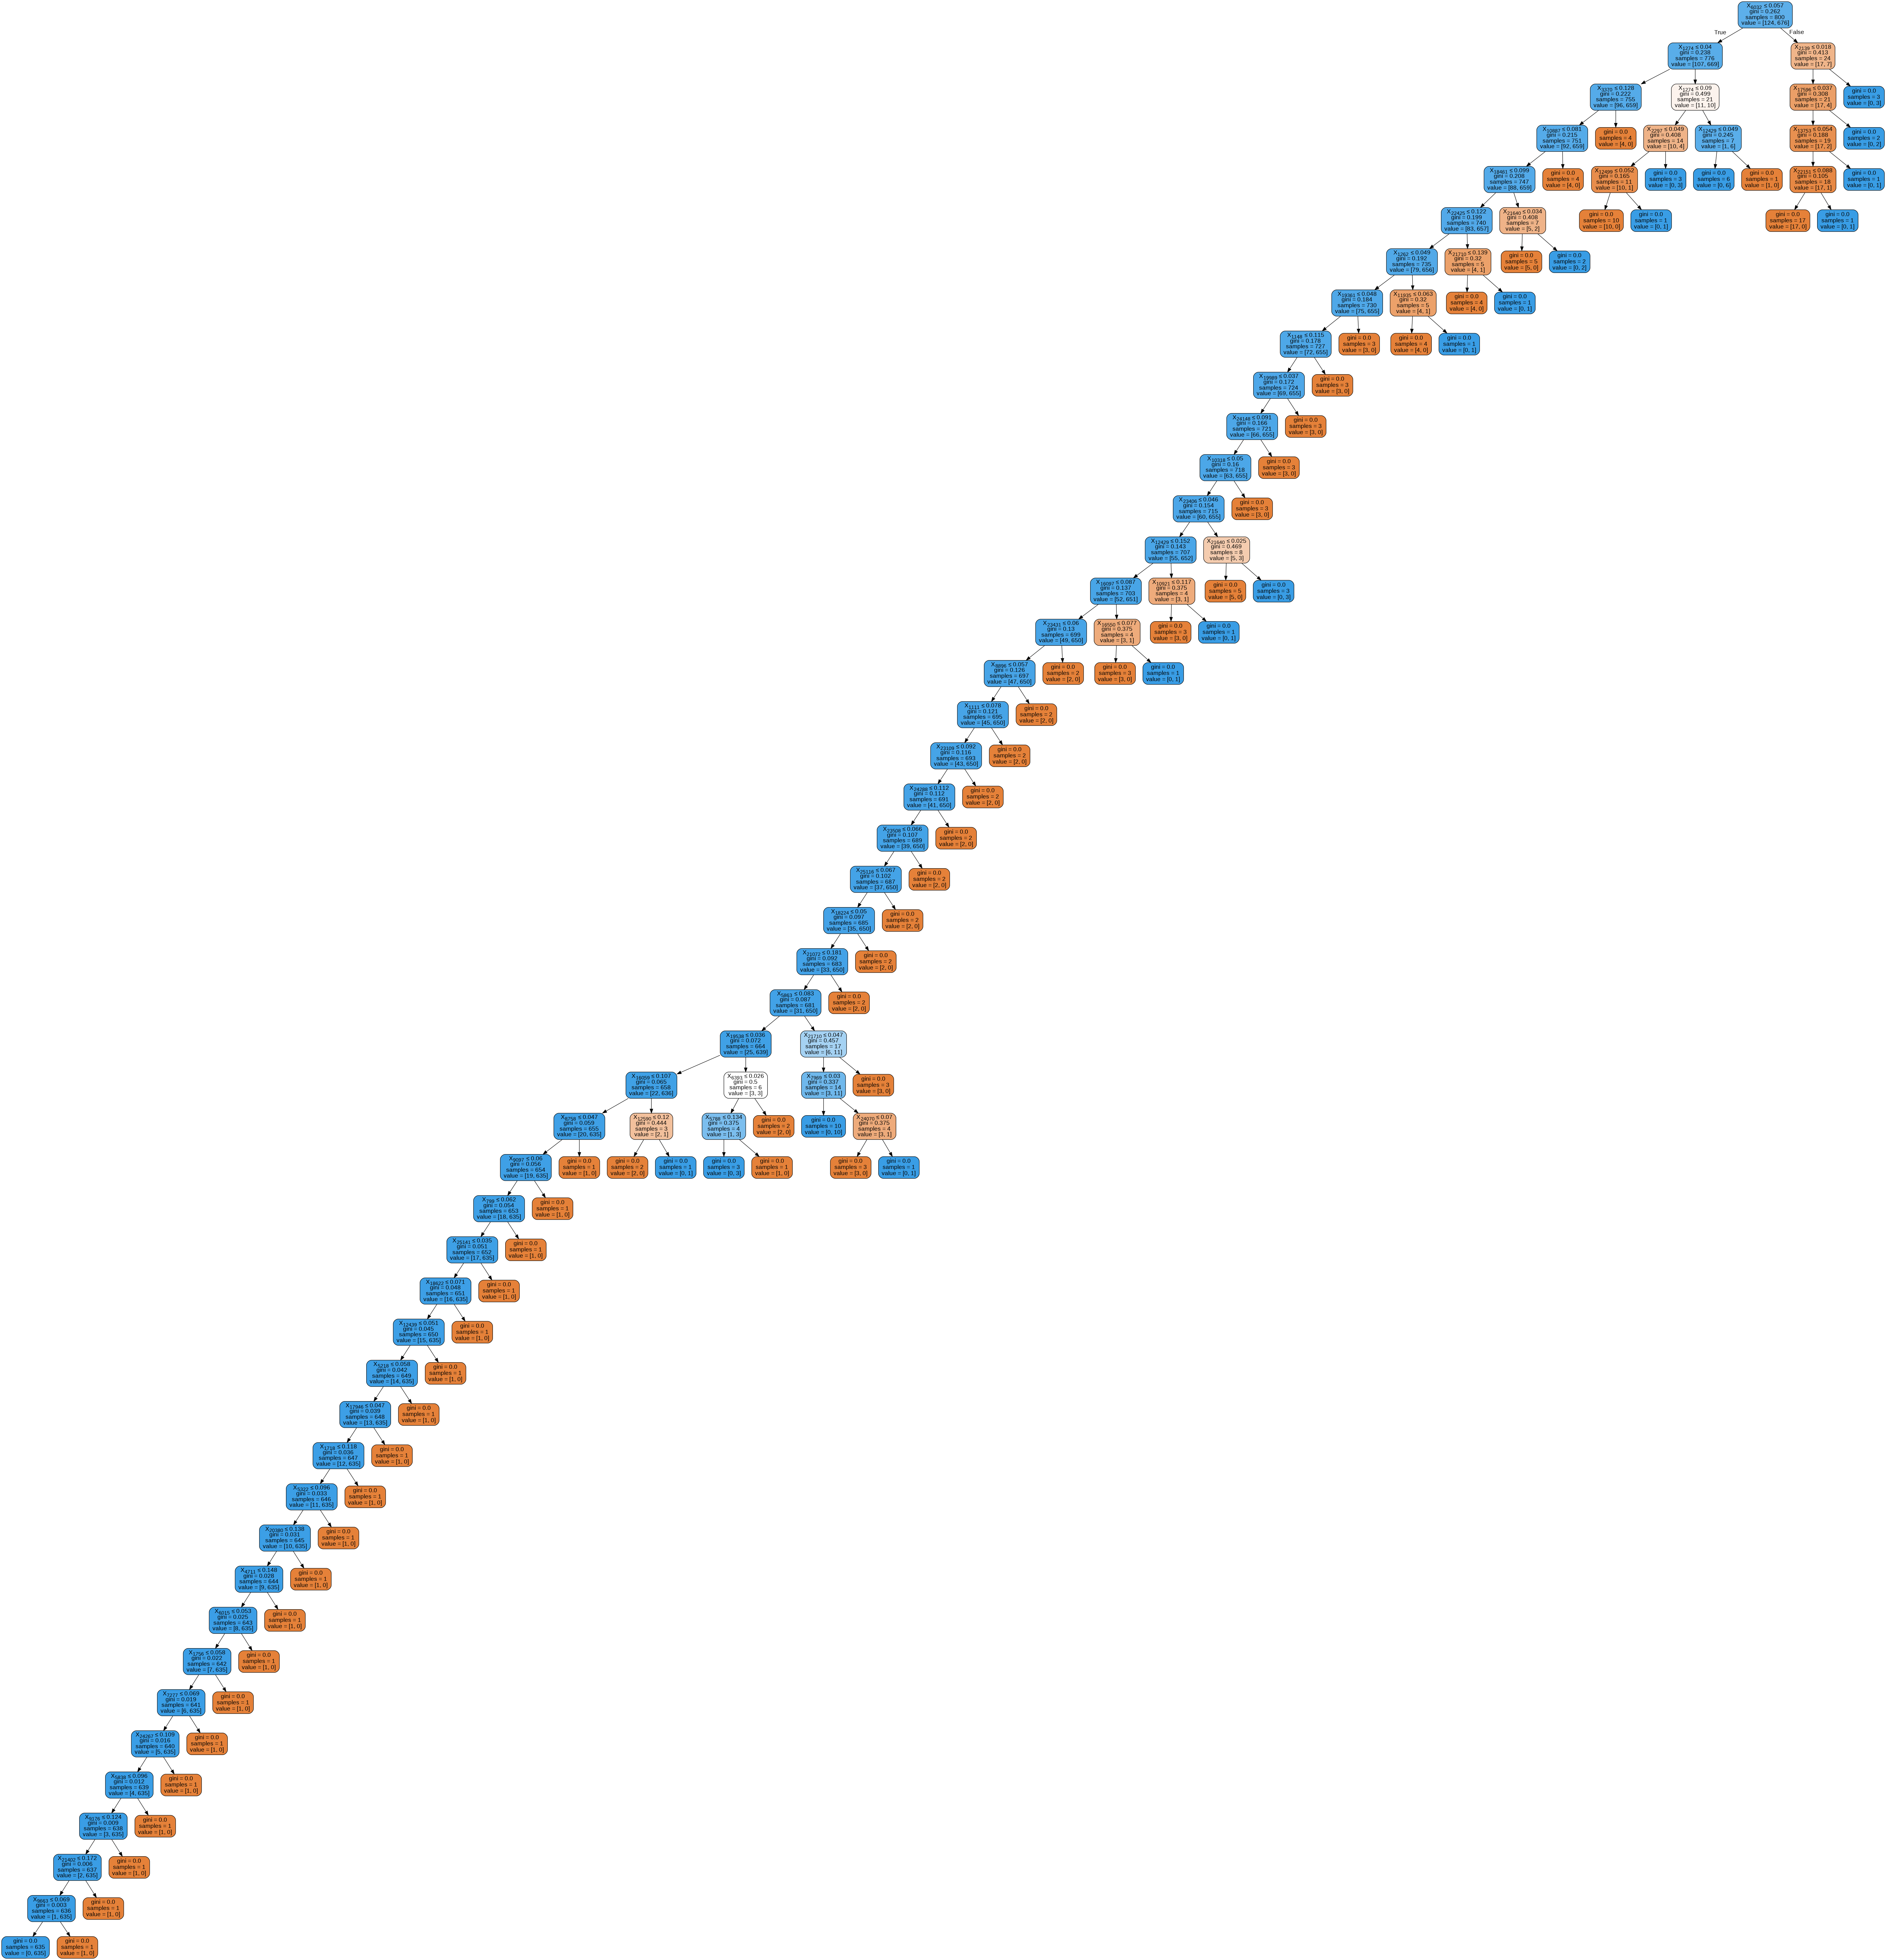

In [0]:
DT= DecisionTreeClassifier(max_depth=53)
fit=DT.fit(x_tr_tfidf,y_tr)
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 6 Word2Vec

In [0]:
i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  1015
sample words  ['big', 'lover', 'fig', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'must', 'tri', 'hard', 'ever', 'write', 'review', 'rice', 'good', 'live', 'never', 'seen', 'sale', 'store', 'came', 'across', 'search', 'amazon', 'glad', 'gave', 'think', 'youll', 'disappoint', 'ad', 'chicken', 'suggest', 'also', 'small', 'anoth', 'great', 'way', 'make', 'even', 'better', 'fresh', 'mango', 'cant', 'find', 'use', 'can', 'substitut', 'cup']


# 7.Avg W2V

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

80000
50


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

20000
50


In [0]:
x_test_av1=sent_vectors_test
x_tr_av1=sent_vectors

# 7.1 Gridsearch

## 7.1.1 Finding the optimal MaxDepth using GridSearchcv 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 14.1min finished


Best HyperParameter:  {'max_depth': 7}
0.8342940037727707


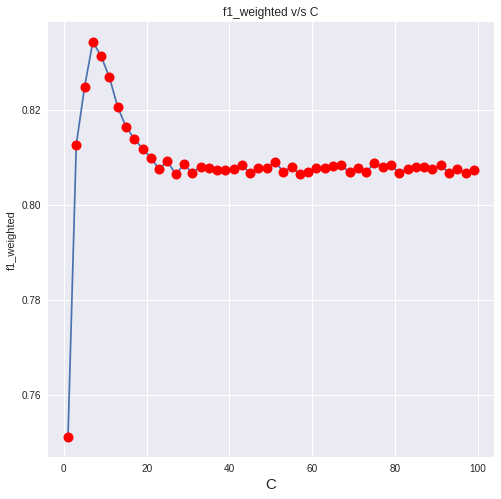

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))

DT = DecisionTreeClassifier()
max_depth = [{'max_depth': depth}]
gsv = GridSearchCV(DT,max_depth,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 7.1.2 finding the accuracy in Test data using optimal MaxDepth

Accuracy on test set: 84.755%
Precision on test set: 0.750
Recall on test set: 0.652
F1-Score on test set: 0.680


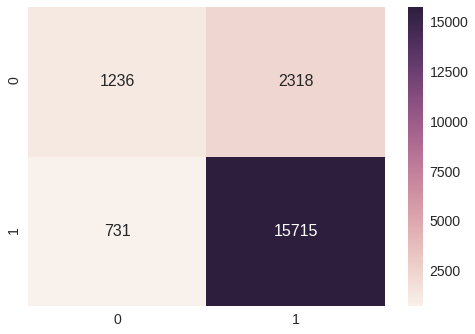

In [0]:
DT= DecisionTreeClassifier(max_depth=7)
DT.fit(x_tr_av1,y_tr)
y_pred =DT.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 7.2 RandomSearchCv

## 7.2.1 Finding the optimal MaxDepth using RandomSearchCv

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.1min finished


Best HyperParameter:  {'max_depth': 19}
0.8044119903913634


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


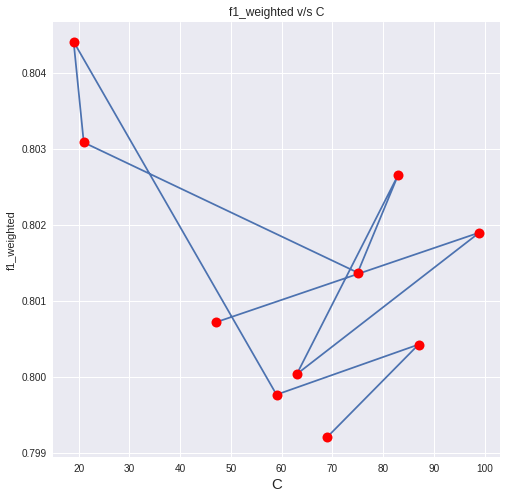

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))
DT = DecisionTreeClassifier()
max_depth = {'max_depth':depth}
gsv = RandomizedSearchCV(DT,max_depth,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 7.2.2 Finding the optimal MaxDepth using GridSearch

Accuracy on test set: 84.390%
Precision on test set: 0.733
Recall on test set: 0.690
F1-Score on test set: 0.707


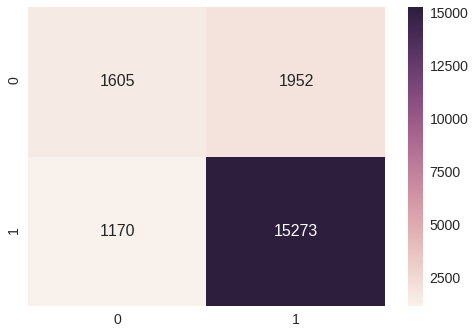

In [0]:
DT= DecisionTreeClassifier(max_depth=19)
DT.fit(x_tr_av1,y_tr)
y_pred =DT.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 7.1.4 Decision Tree visualisation 

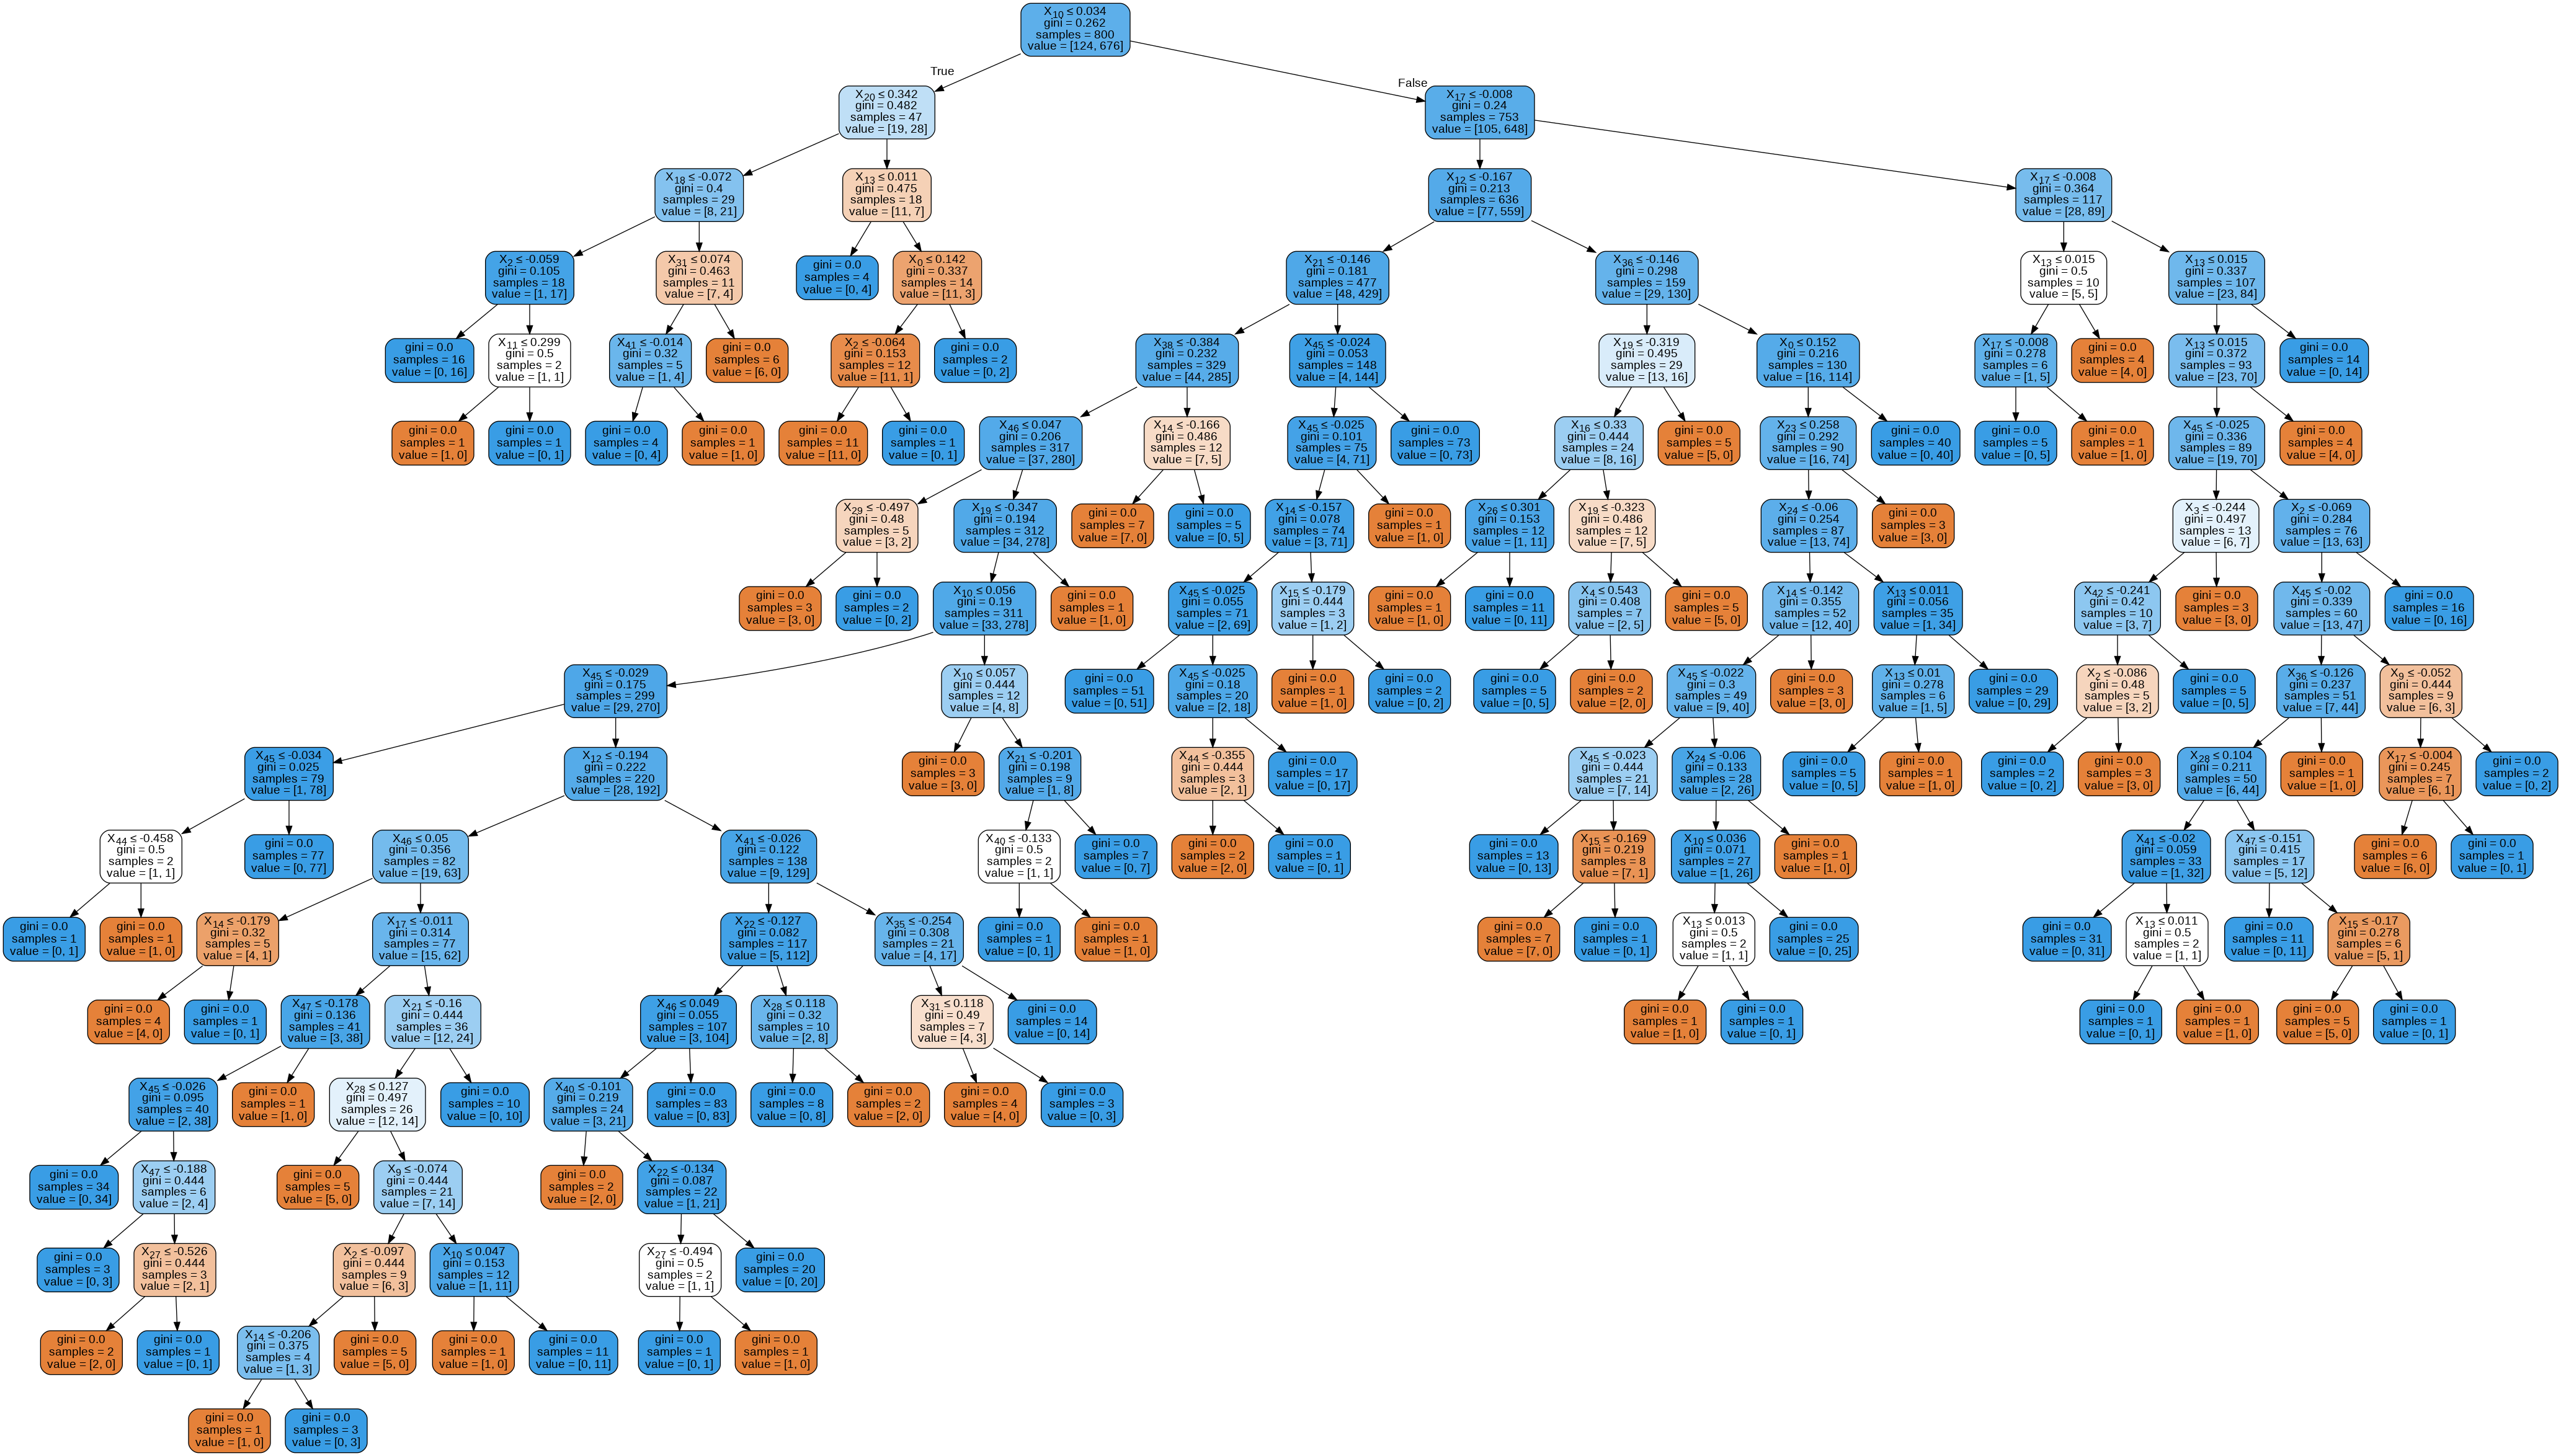

In [0]:
DT= DecisionTreeClassifier(max_depth=19)
fit=DT.fit(x_tr_av1,y_tr)
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 8. TFIDF-W2V

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_tr)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [02:14<00:00, 595.96it/s]


In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:35<00:00, 563.56it/s]


In [0]:
x_test_tdfw2v=tfidf_sent_vectors_test
x_tr_tdfw2v=tfidf_sent_vectors

## 8.1 GridSearch

### 8.1.1 Finding the optimal MaxDepth using GridSearch

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 14.1min finished


Best HyperParameter:  {'max_depth': 9}
0.8231140112767492


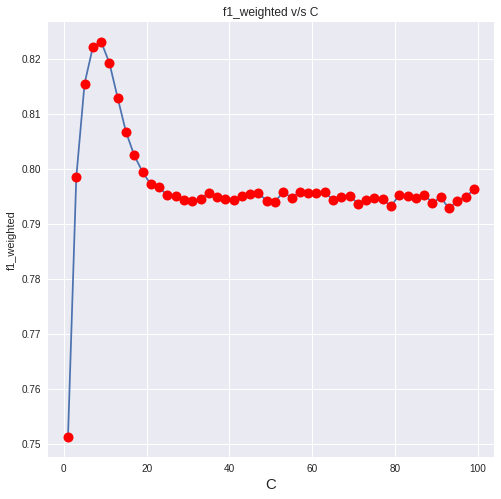

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))

DT = DecisionTreeClassifier()
C_value = [{'max_depth': depth}]
gsv = GridSearchCV(DT,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 8.1.2 finding the accuracy in Test data using optimal MaxDepth

Accuracy on test set: 83.665%
Precision on test set: 0.719
Recall on test set: 0.634
F1-Score on test set: 0.658


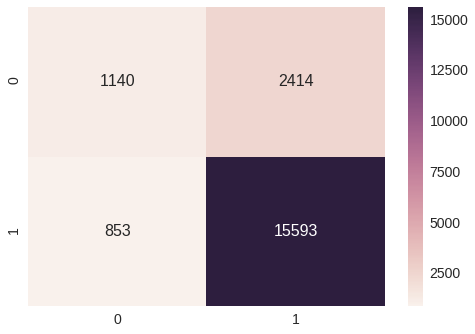

In [0]:
DT= DecisionTreeClassifier(max_depth=9)
DT.fit(x_tr_tdfw2v,y_tr)
y_pred =DT.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 8.2 RandomSearchcv


### 8.2.1 Finding the optimal MaxDepth using RandomSearch

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.0min finished


Best HyperParameter:  {'max_depth': 11}
0.8103336485354614


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


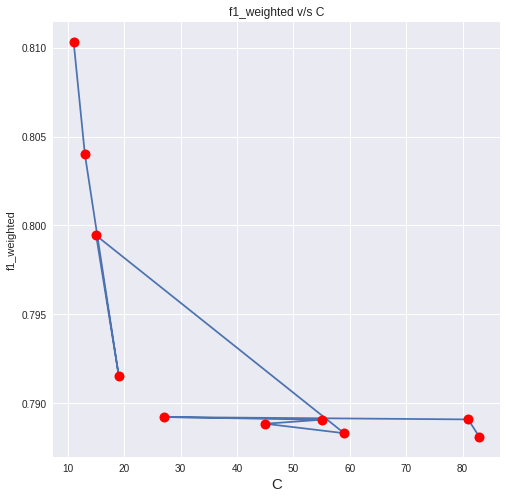

In [0]:
myList = list(range(0,100))
depth = list(filter(lambda x: x % 2 != 0, myList))
DT = DecisionTreeClassifier()
max_depth = {'max_depth':depth}
gsv = RandomizedSearchCV(DT,max_depth,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlabel("C",fontsize=15)
plt.ylabel("f1_weighted")
plt.title('f1_weighted v/s C')
plt.plot(x,y, marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 8.1.2 finding the accuracy in Test data using optimal MaxDepth

Accuracy on test set: 82.895%
Precision on test set: 0.699
Recall on test set: 0.647
F1-Score on test set: 0.665


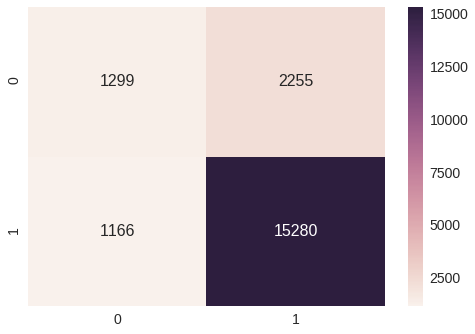

In [0]:
DT= DecisionTreeClassifier(max_depth=11)
DT.fit(x_tr_tdfw2v,y_tr)
y_pred =DT.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 8.1.3 Decision Tree visualisation 

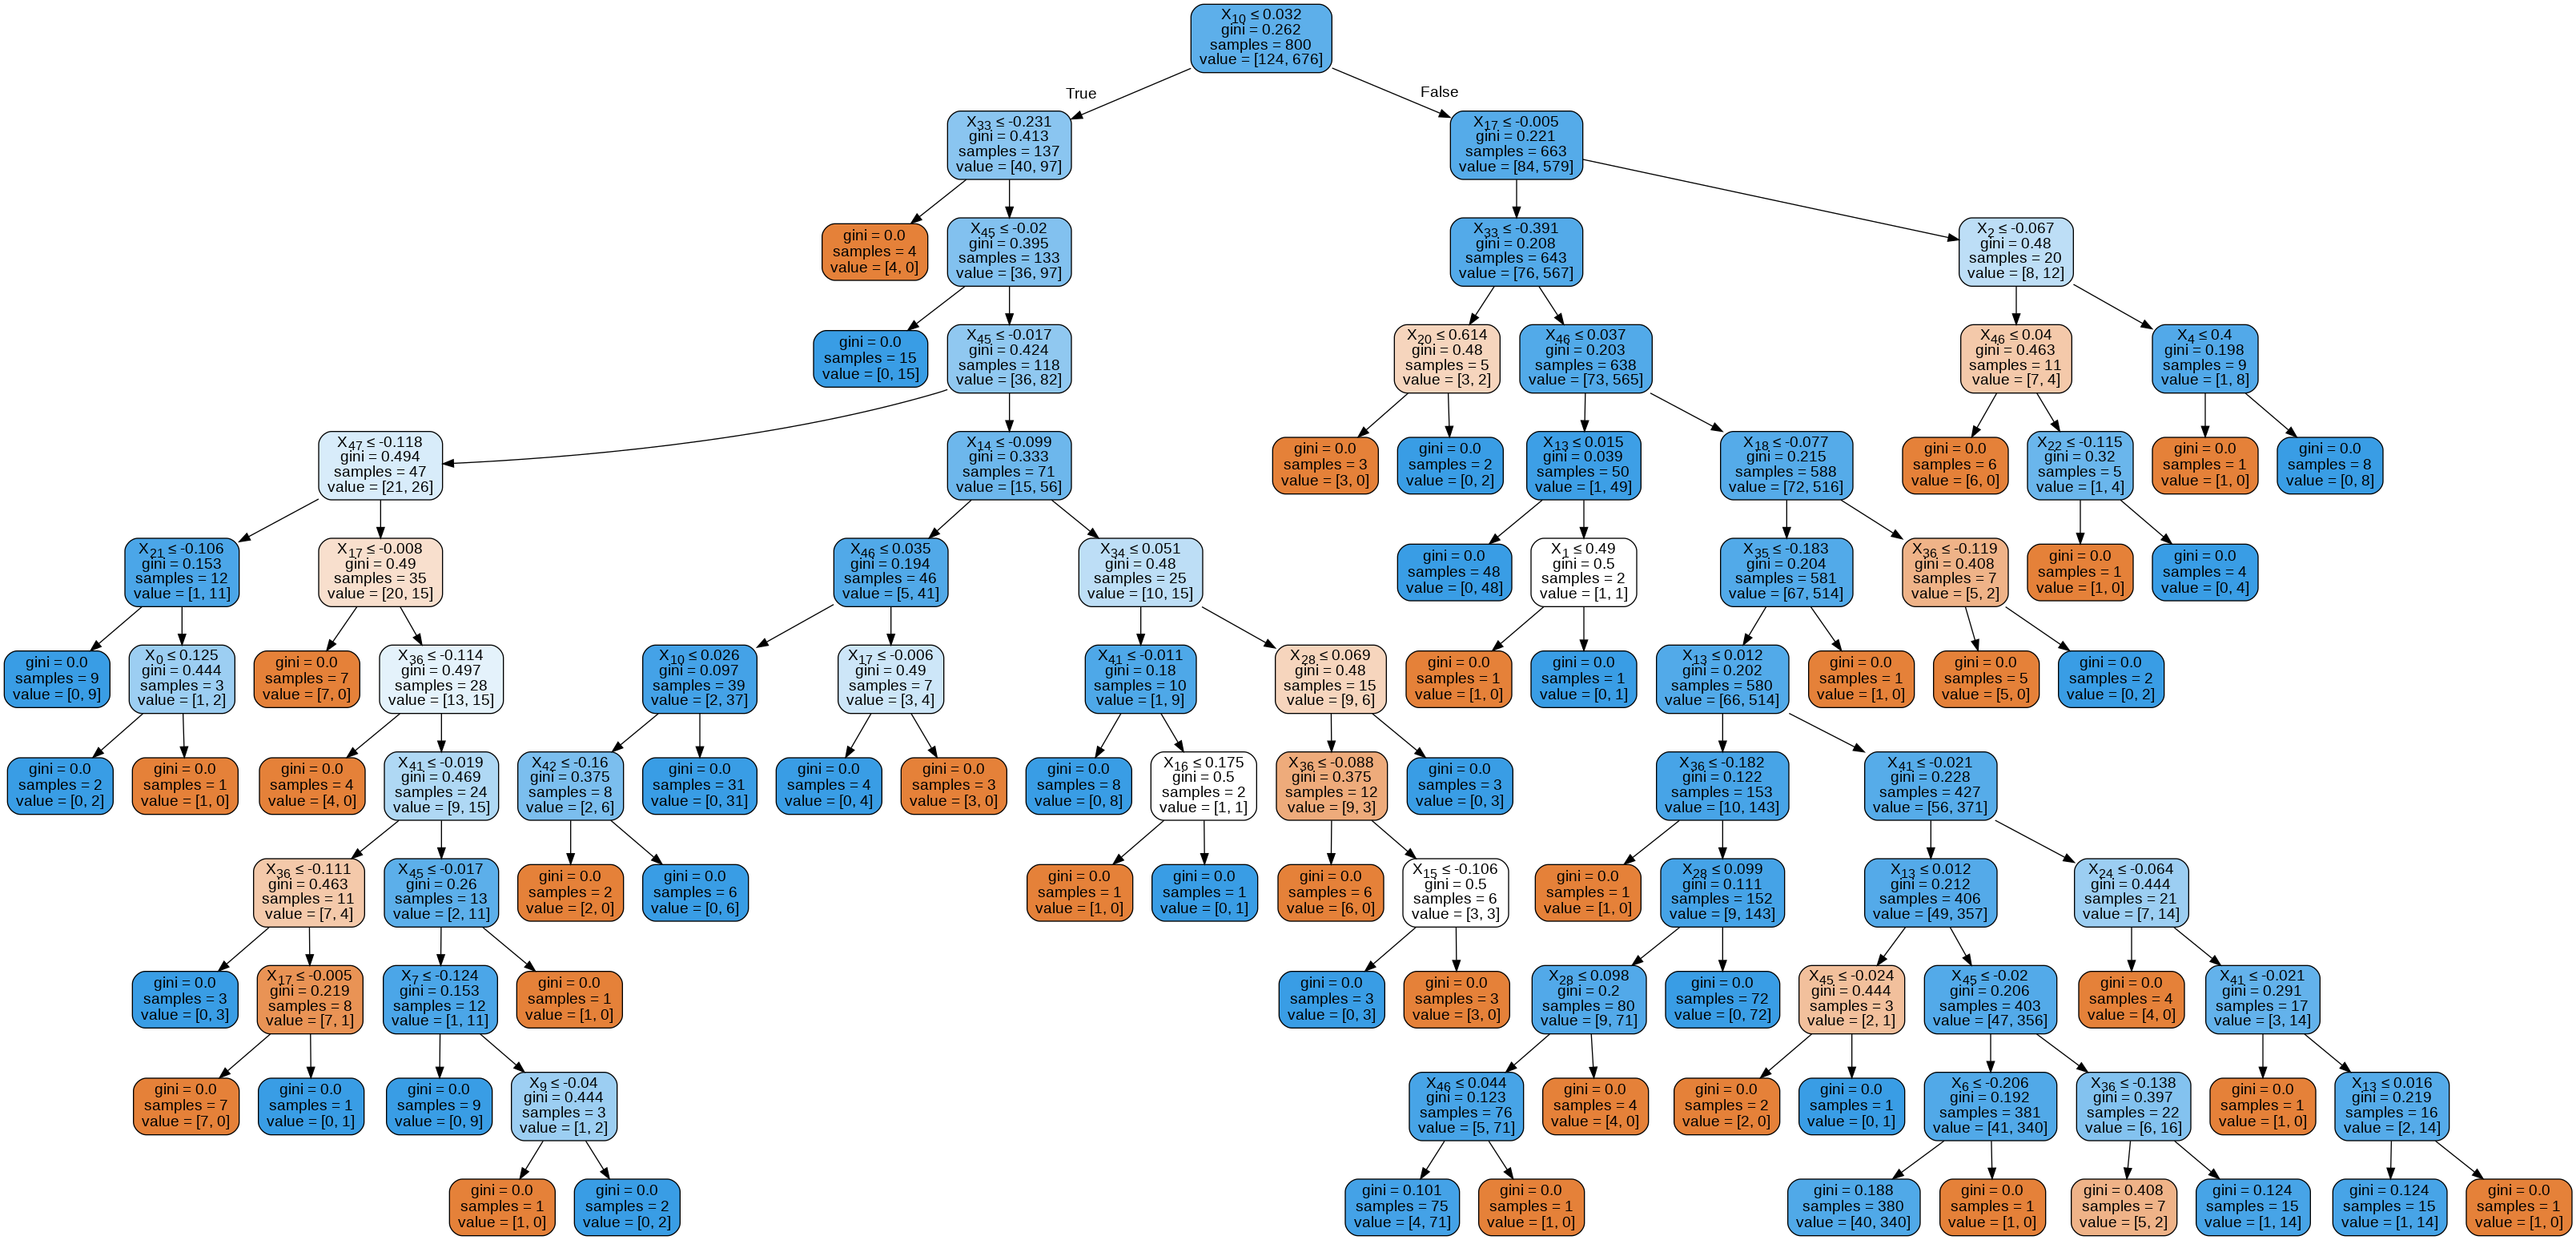

In [0]:
DT= DecisionTreeClassifier(max_depth=11)
fit=DT.fit(x_tr_tdfw2v,y_tr)
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# GridSearch Conclusion



| Model | hyper parameter   |F1score test|accuracy Test
|------|------|------|------|
|  unigram  | 43| 0.700|84.665%|
| Bi-gram | 75|0.723| 85.275%|
|  Tf-IDF | 53| 0.717| 84.600%|
| Av-Word2Vec |7|0.680|84.75%|
|  Tf-IDF Word2vec |9|0.656| 83.66%|


# RandomSearch Conclusion



| Model | hyper parameter   |F1score test|accuracy Test
|------|------|------|------|
|  unigram  |47|0.701|84.565%|
| Bi-gram | 89|0.720|85.335%|
|  Tf-IDF | 33|0.690|85.145%|
| Av-Word2Vec | 19|0.707|84.390%|
|  Tf-IDF Word2vec |11|0.669|82.892%|
